In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from gaussian_mixture_grid import GaussianMixtureGrid
import numpy as np

# Gaussian Mixture Grid

## The Distributions

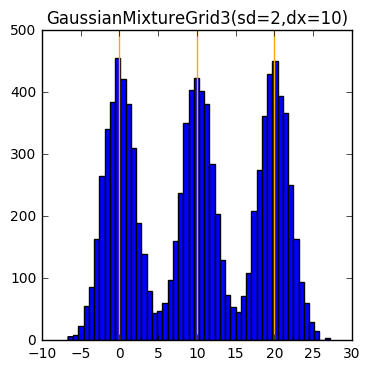

In [2]:
gr1d = GaussianMixtureGrid(3, 1, 10, 2)
plt.figure(figsize=(4,4))
plt.title(gr1d.name)
plt.hist(gr1d.sample(10000), bins=50)
for mu in gr1d.means:
  plt.axvline(mu, c='orange')
plt.show()

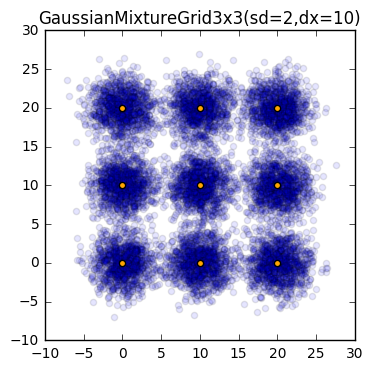

In [3]:
gr2d = GaussianMixtureGrid(3, 2, 10, 2)
plt.figure(figsize=(4,4))
plt.title(gr2d.name)
plt.scatter(*gr2d.sample(10000).T, alpha=0.1)
plt.scatter(*gr2d.means.T, c='orange')
plt.show()

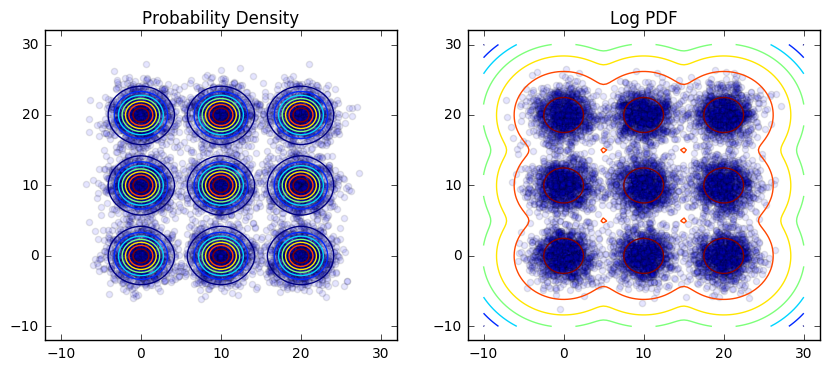

In [4]:
s = np.linspace(-10,30,100)
X,Y = np.meshgrid(s,s)
Z = [[gr2d.logp([x,y]) for x in s] for y in s]

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Probability Density')
plt.scatter(*gr2d.sample(10000).T, alpha=0.1)
plt.contour(X,Y,np.exp(Z))
plt.subplot(122)
plt.title('Log PDF')
plt.contour(X,Y,Z)
plt.scatter(*gr2d.sample(10000).T, alpha=0.1)
plt.show()

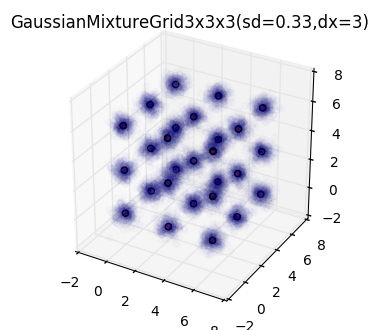

In [5]:
gr3d = GaussianMixtureGrid(3, 3, 3, 0.33)
X, Y, Z = gr3d.sample(10000).T
Xu, Yu, Zu = gr3d.means.T

plt.figure(figsize=(4,4)).add_subplot(111, projection='3d')
plt.title(gr3d.name)
plt.scatter(X, Y, zs=Z, alpha=0.01)
plt.scatter(Xu, Yu, zs=Zu, c='orange')
plt.show()

## Sampling using pymc3

Because our 2d distribution has few dimensions and significant overlap between modes, we'll cover it pretty well:

In [6]:
import pymc3 as pm
with pm.Model() as model:
  mix = gr2d.to_pymc()
  trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 0.027003: 100%|██████████| 200000/200000 [00:11<00:00, 16960.07it/s]
Finished [100%]: Average ELBO = 0.044024
Evidence of divergence detected, inspect ELBO.
100%|██████████| 10000/10000 [00:05<00:00, 1975.77it/s]


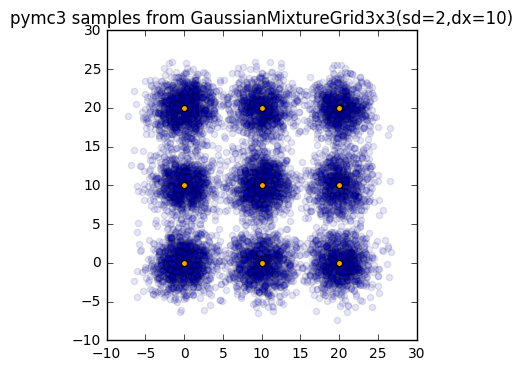

In [9]:
plt.figure(figsize=(4,4))
plt.title('pymc3 samples from {}'.format(gr2d))
plt.scatter(*trace[gr2d.name].T, alpha=0.1)
plt.scatter(*gr2d.means.T, c='orange')
plt.show()

We may not be so lucky with our 3D distribution:

In [10]:
with pm.Model() as model2:
  mix2 = gr3d.to_pymc()
  trace2 = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -0.030873: 100%|██████████| 200000/200000 [00:11<00:00, 16846.28it/s]
Finished [100%]: Average ELBO = -0.02323
Evidence of divergence detected, inspect ELBO.
100%|██████████| 10000/10000 [00:05<00:00, 1807.09it/s]


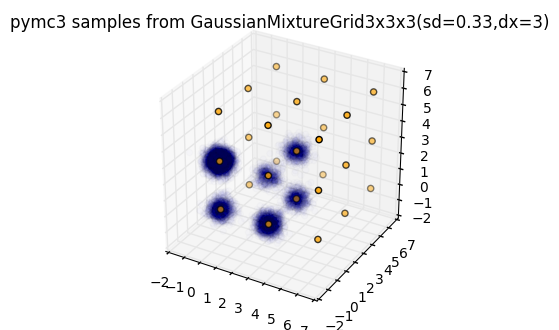

In [11]:
Xs, Ys, Zs = trace2[gr3d.name].T

plt.figure(figsize=(4,4)).add_subplot(111, projection='3d')
plt.title('pymc3 samples from {}'.format(gr3d))
plt.scatter(Xs, Ys, zs=Zs, alpha=0.01)
plt.scatter(Xu, Yu, zs=Zu, c='orange')
plt.show()

## Rejection sampling

We can rejection sample instead!

In [15]:
rsamps1 = gr1d.rejection_sample_bounding_box(10000)
rsamps2 = gr2d.rejection_sample_bounding_box(10000)
rsamps3 = gr3d.rejection_sample_bounding_box(10000)

print(len(rsamps1), len(rsamps2), len(rsamps3))

4698 2211 275


As we increase the dimensionality, we decrease the efficiency of rejection sampling. However, samples are drawn from every mode:

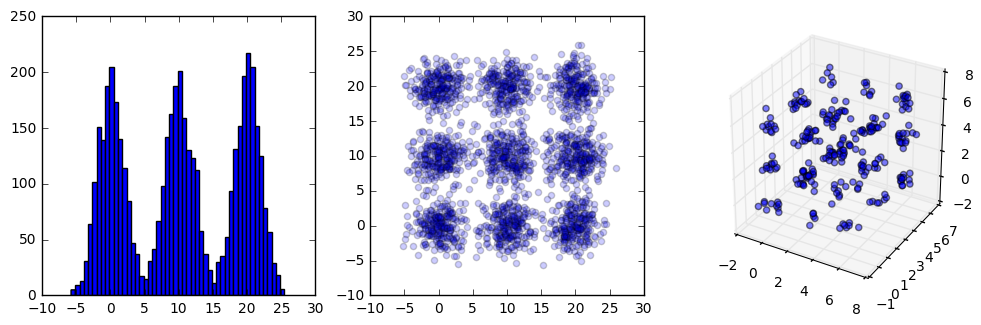

In [18]:
plt.figure(figsize=(12,3.6))

plt.subplot(131)
plt.hist(rsamps1, bins=50)

plt.subplot(132)
plt.scatter(*rsamps2.T, alpha=0.2)

plt.subplot(133, projection='3d')
Xr,Yr,Zr = rsamps3.T
plt.scatter(Xr,Yr,zs=Zr, alpha=0.5)

plt.show()

Can combining these two techniques produce more uncorrelated samples faster?